# Read the data and rename some parameters
Ref: He et al., 2011, SIMULATING TRANSIENT CLIMATE EVOLUTION OF THE LAST DEGLACIATION WITH CCSM3

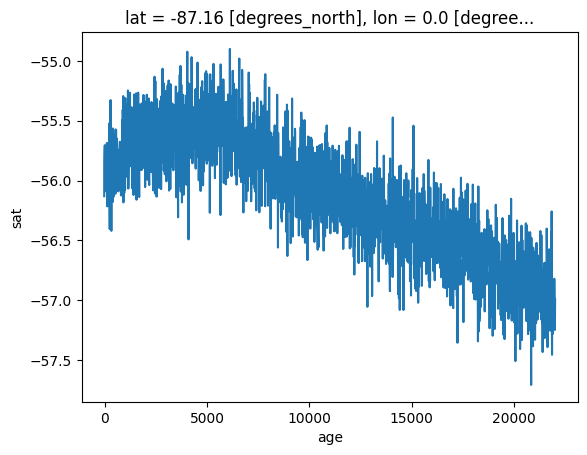

In [2]:
import xarray as xr

# import .nc data
ds = xr.open_dataset('TraCE_data/b30.00_4kaDVTj.cam2.ncrcat.ann.nc')

# rename the TREFHT to sat
ds = ds.rename({'TREFHT': 'sat'})
# rename the time to age
ds = ds.rename({'time': 'age'})
# multiply age by 1000
ds['age'] = ds['age'] * -1000

# convert the sat to degrees C
ds['sat'] = ds['sat'] - 273.15

ds = ds[['sat']]
ds
# plot a record from the ds_sat at given lat and lon
ds['sat'].isel(lat=0, lon=0).plot()

# The age of LGMR data starts from 100 and ends at 23900 with step of 200 yr. The age of TraCE starts from -29 and ends at 22000, so we resample the TraCE data to match the resolution of LGMR

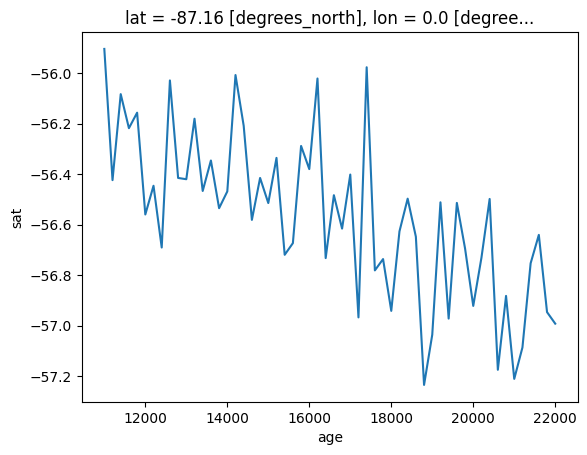

In [3]:
import numpy as np
import xarray as xr

# smoothed_sat = ds['sat'].rolling(age=10, center=True).mean()
smoothed_sat = ds['sat'].rolling(age=10, center=True, min_periods=1).mean()


# Ensure new_age is within the bounds of the original 'age' data
new_age = np.arange(11000, 22001, 200)

# Interpolate the smoothed 'sat' data variable to the new 'age' coordinate
# resampled_sat = smoothed_sat.interp(age=new_age)
resampled_sat=ds['sat'].interp(age=new_age, method='linear')


# Create a new xarray Dataset with the resampled 'sat' data variable
ds_sat = resampled_sat.to_dataset(name='sat')

# ds_sat
# plot a record from the ds_sat at given lat and lon
ds_sat['sat'].isel(lat=0, lon=0).plot()

# Alternative, don't resample data, just crop the data for age>11

In [57]:
ds_sat=ds
ds_sat = ds_sat.where(ds_sat.age>=11000, drop=True)

# PCA

shape of the weight: (48,)
shape of the reshaped sat_centered_weighted: (56, 4608)


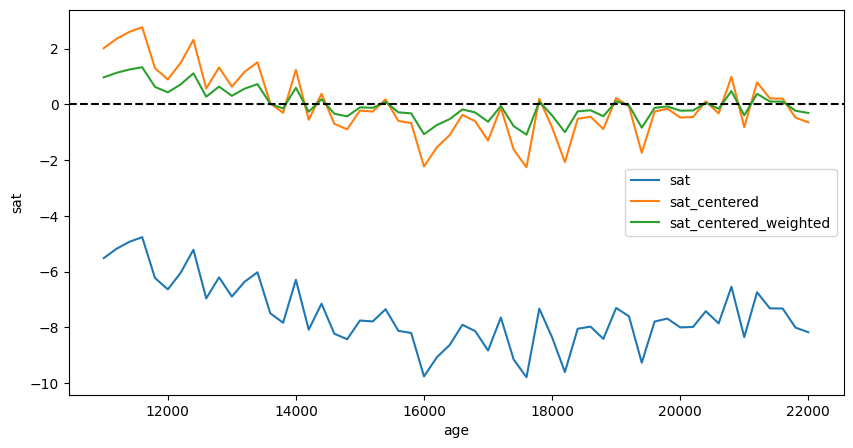

In [4]:
from toolbox import PCA_functions as pf
# 1. Center the Data
ds_sat = pf.center_data(ds_sat)

# 2. Weight the Data
ds_sat = pf.apply_weighting(ds_sat)

# 3. Plot the Centered and Weighted Data
# Assuming you want to plot data for lat=0 and lon=0
lat_index = 40
lon_index = 90
pf.plot_sat_variables(ds_sat, lat_index, lon_index)


In [5]:
from toolbox import PCA_functions as pf
# 4. Perform PCA
exp_variance, eofs, pcs = pf.sat_PCA(ds_sat)
print('Explained variance:', exp_variance)


shape of the reshaped sat_centered_weighted: (4608, 56)
shape of u, s, vh: (4608, 4608) (56,) (56, 56)
shape of EOFs: (4608, 2)
shape of PCs: (56, 2)
Explained variance: [7.79539558e-01 6.38530713e-02 2.22232120e-02 1.76567869e-02
 1.22540317e-02 8.98181415e-03 7.86196288e-03 7.62631802e-03
 6.39888478e-03 5.31823251e-03 4.55062238e-03 4.32892243e-03
 3.99160715e-03 3.75564327e-03 3.35738893e-03 3.09897818e-03
 2.78335139e-03 2.56034139e-03 2.42486697e-03 2.27300174e-03
 2.11312540e-03 1.98540508e-03 1.81360724e-03 1.75834280e-03
 1.63751710e-03 1.53892960e-03 1.48993042e-03 1.44452821e-03
 1.32458559e-03 1.28493895e-03 1.26212271e-03 1.16295464e-03
 1.08354396e-03 1.04499461e-03 1.00604179e-03 9.70709976e-04
 9.60796209e-04 8.82519209e-04 8.73986119e-04 8.37866449e-04
 8.02710685e-04 7.38428576e-04 7.14368293e-04 6.99986008e-04
 6.50978101e-04 6.32979154e-04 5.97182324e-04 5.92414105e-04
 5.58703076e-04 5.11889899e-04 4.87125053e-04 4.65812038e-04
 4.42205395e-04 4.17170089e-04 3.7300

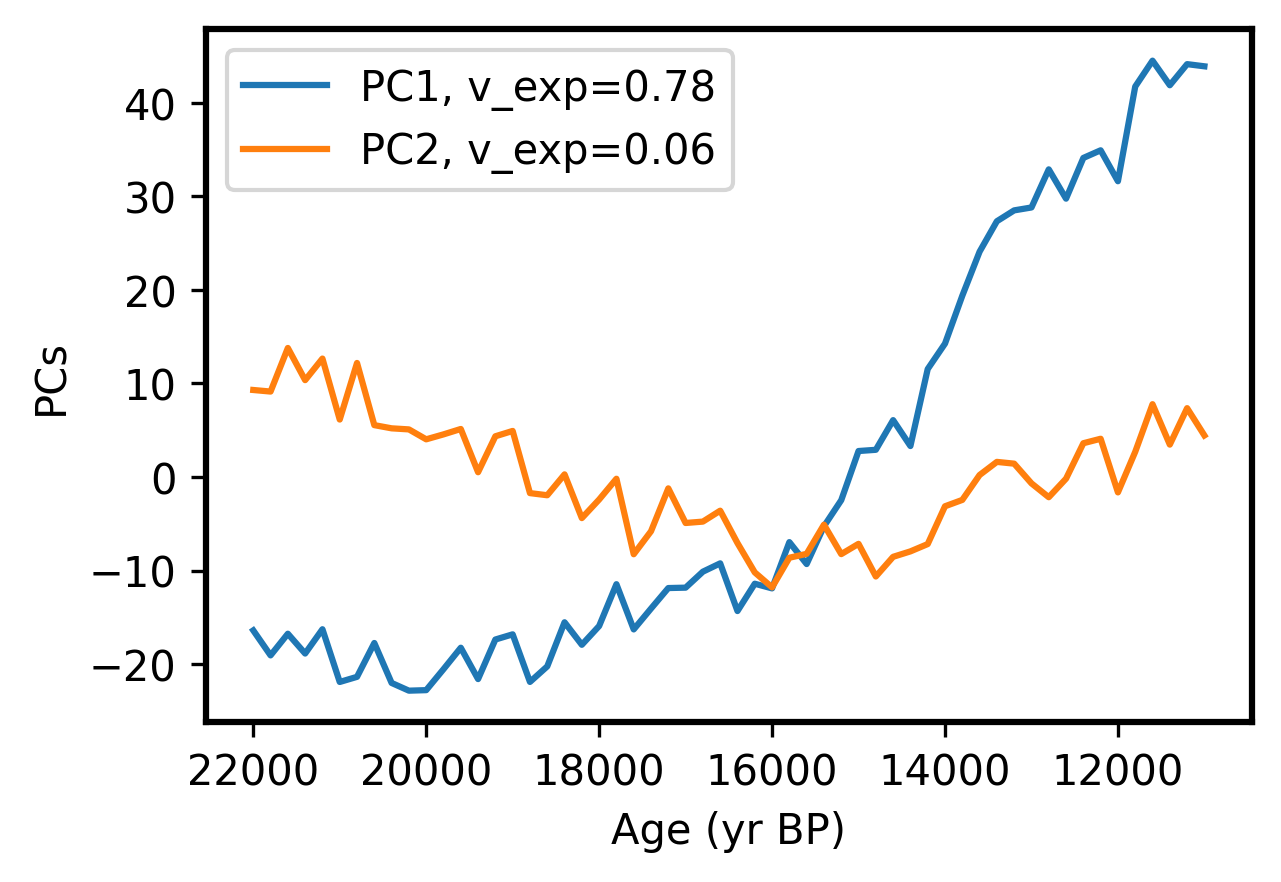

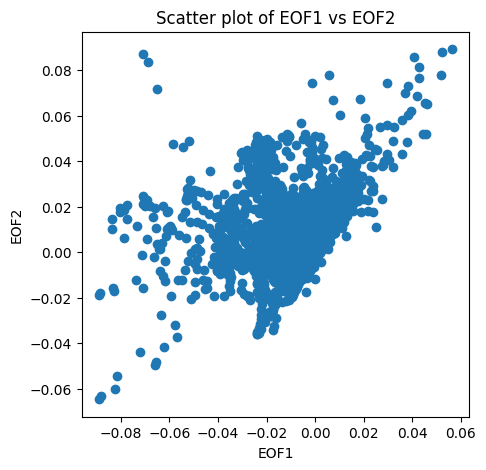

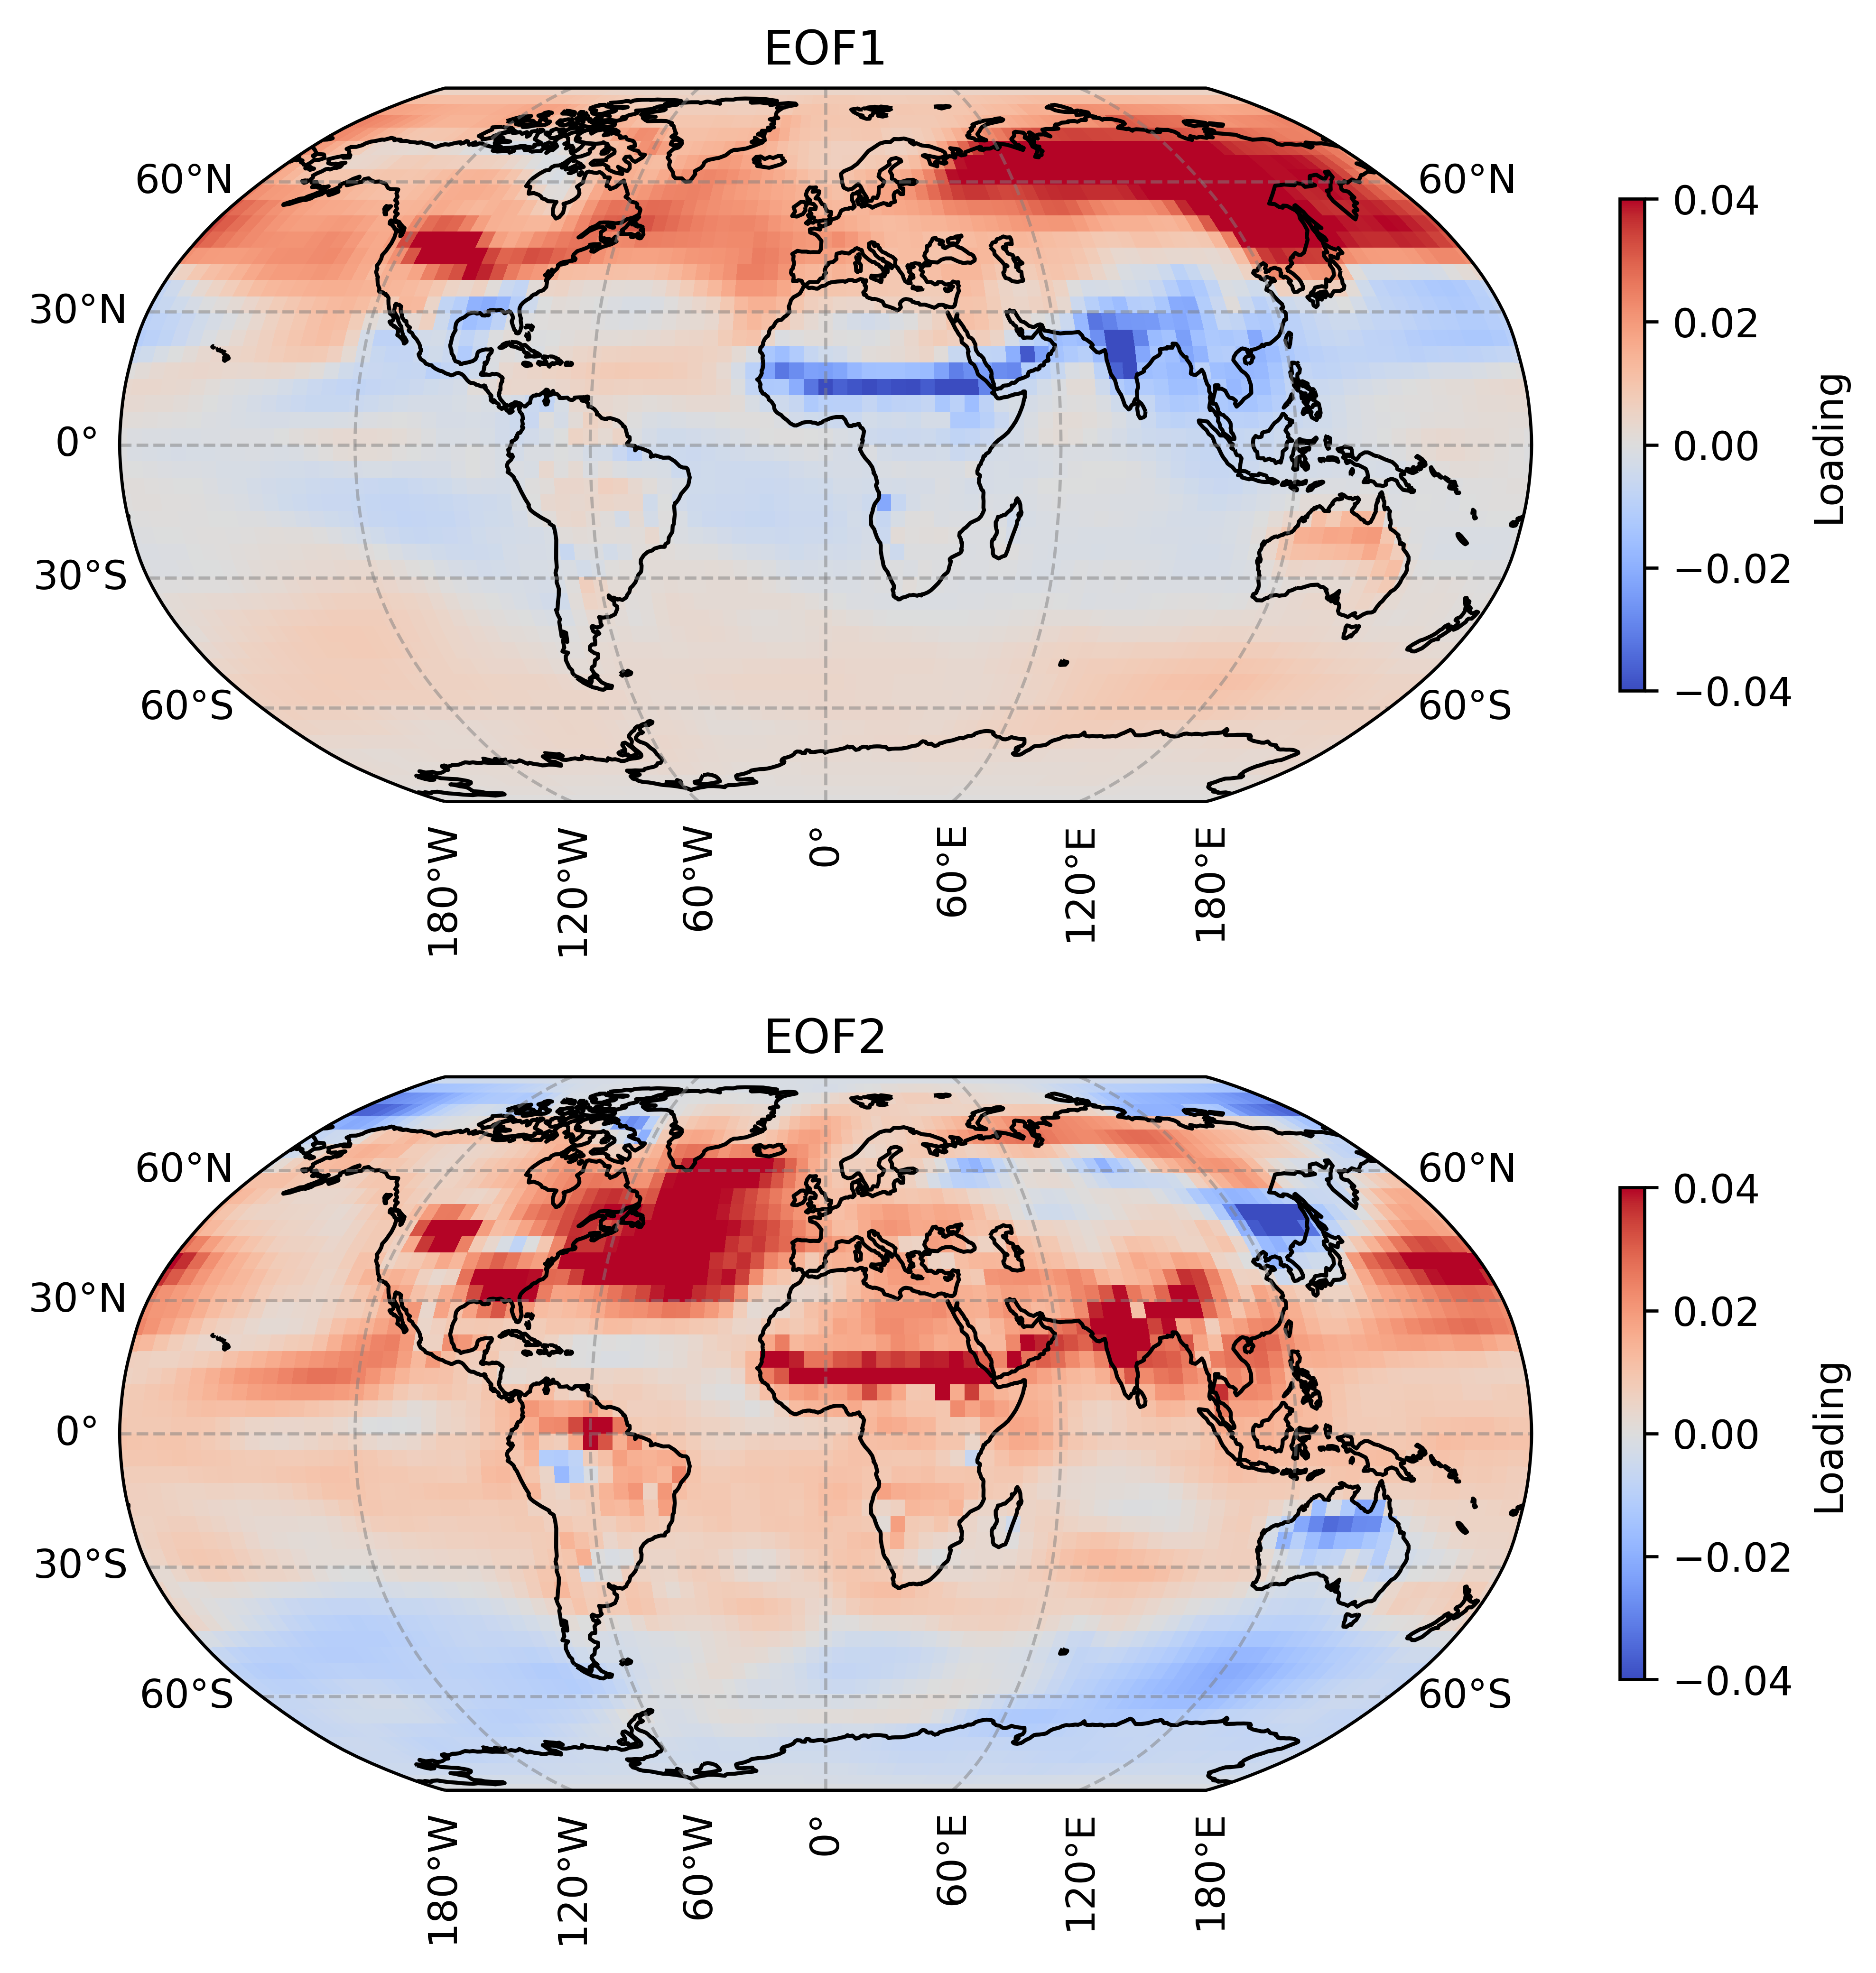

(<Figure size 4800x5400 with 4 Axes>,
 array([<GeoAxesSubplot: title={'center': 'EOF1'}>,
        <GeoAxesSubplot: title={'center': 'EOF2'}>], dtype=object))

In [6]:
# 5. Plot PCs
pf.plot_pcs(ds_sat['age'].values, pcs, exp_variance)

# 6. Plot EOF Scatter
pf.plot_eof_scatter(eofs)

# 7. Plot the EOF Map
pf.plot_eof_map(eofs, ds_sat['lat'].values, ds_sat['lon'].values)

# GMM

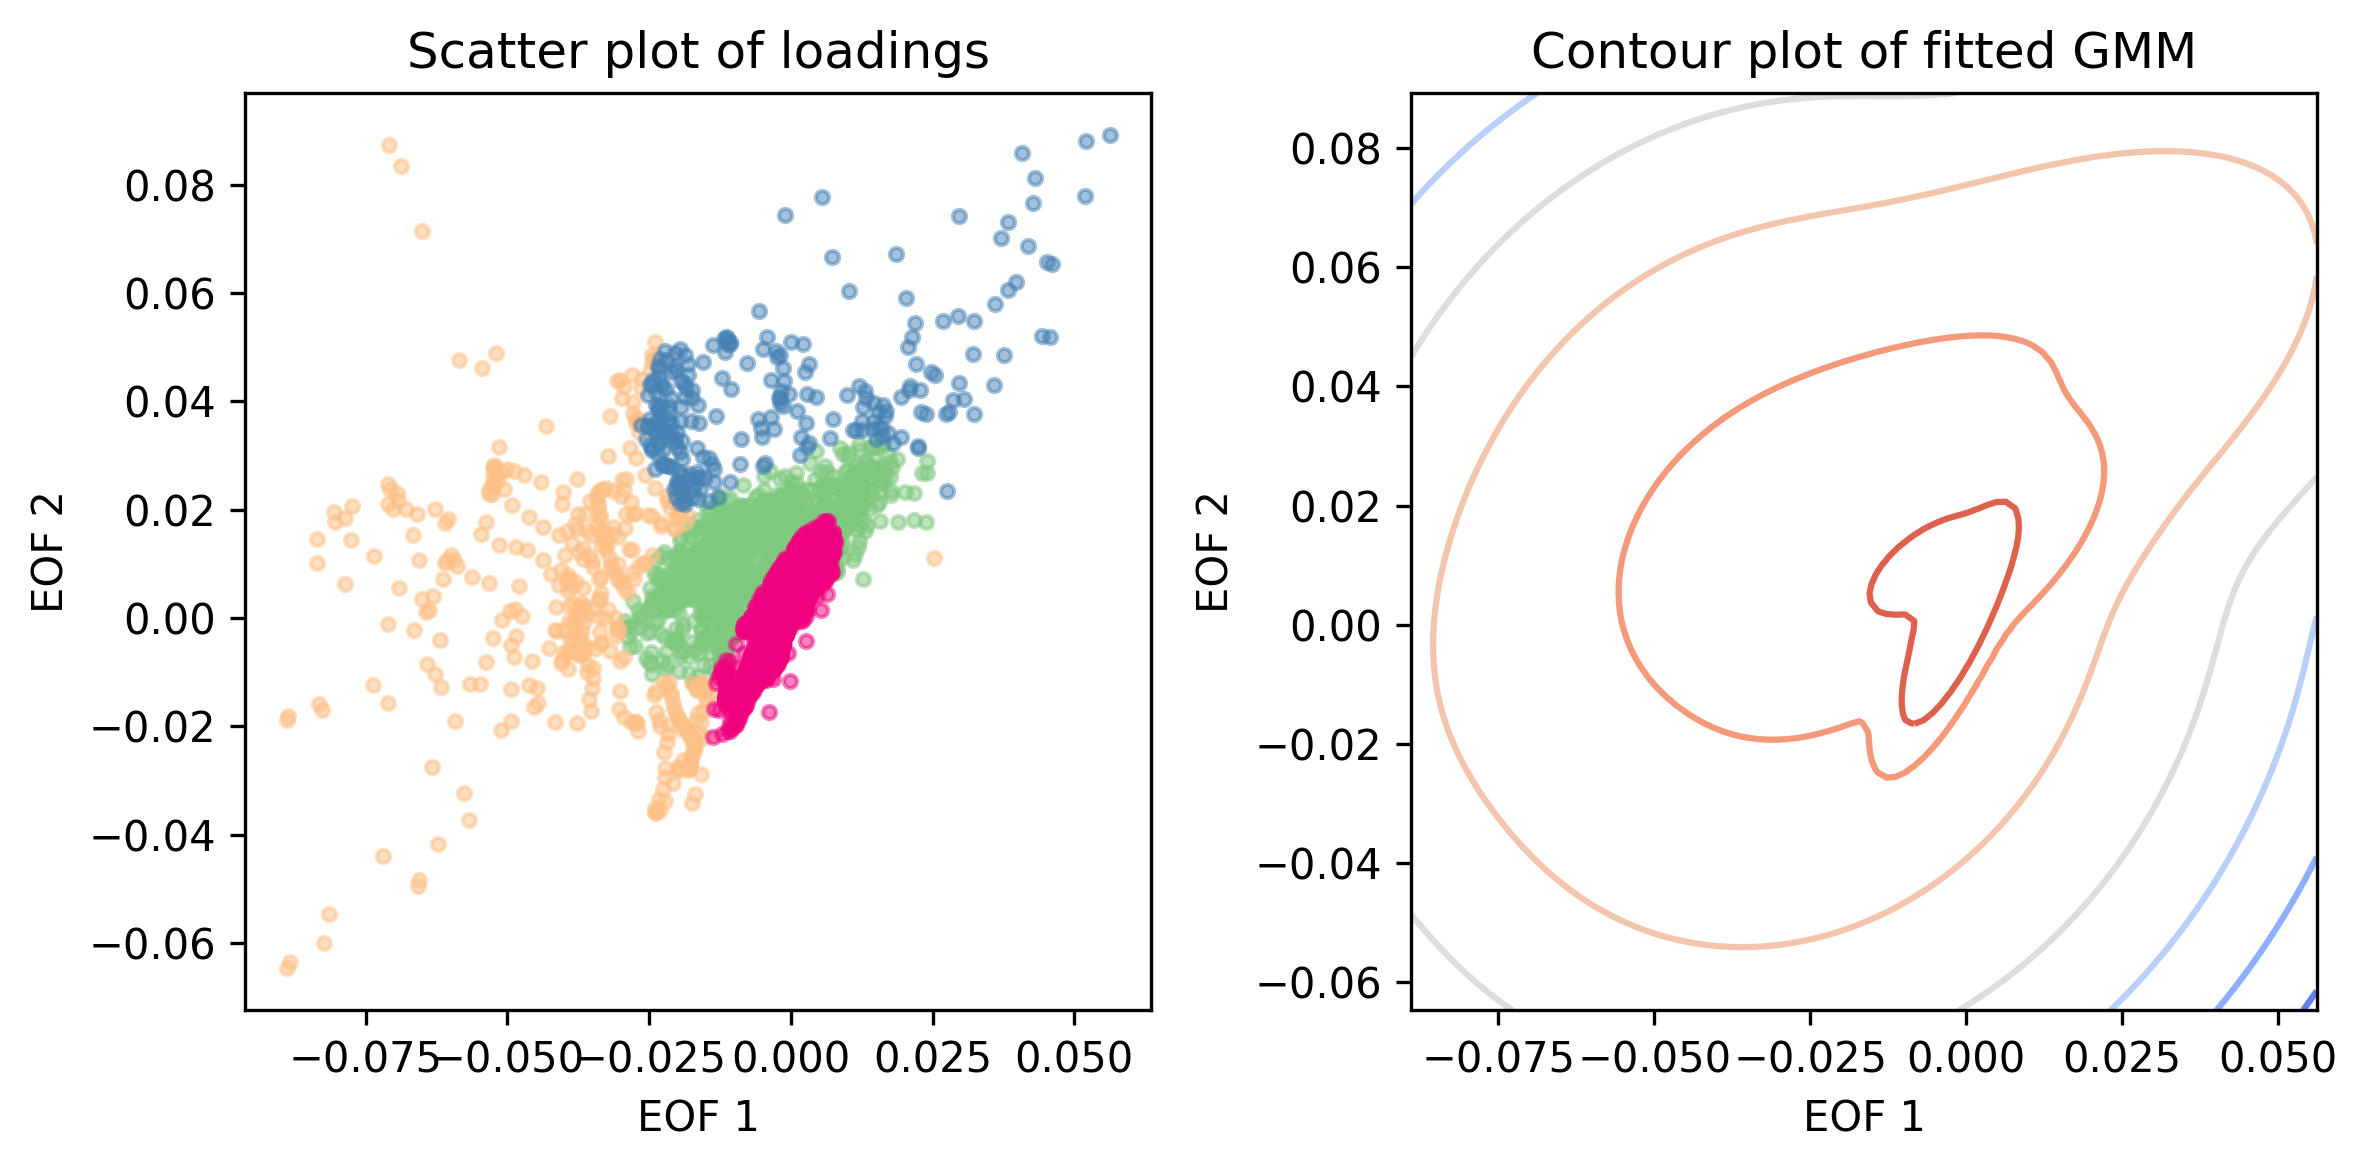

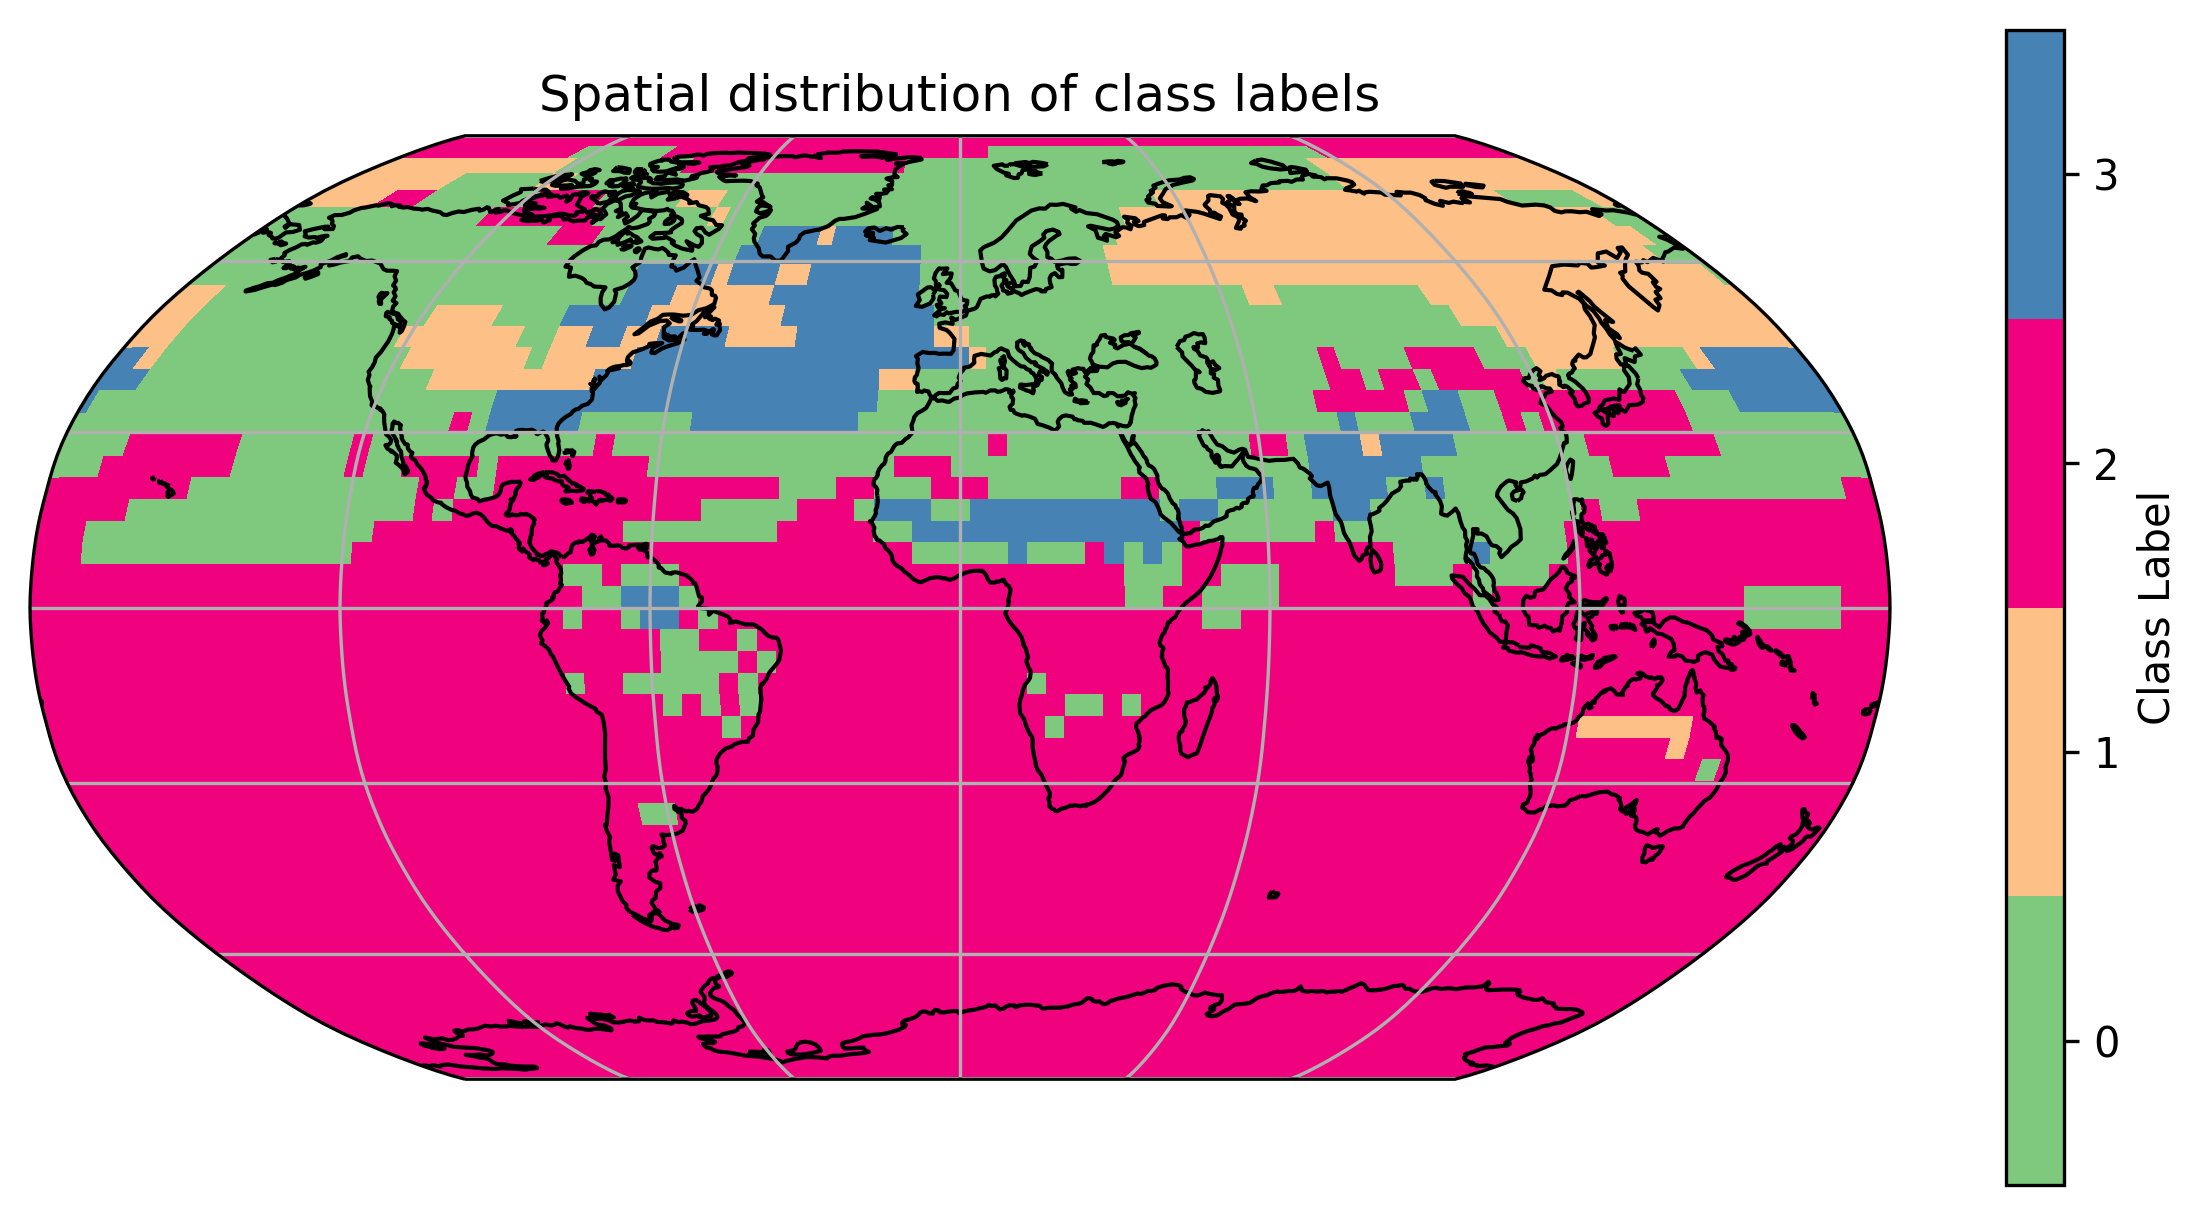

In [9]:
from toolbox import GMM_functions as gf
ds_EOFs_GMM,reshaped_probs=gf.GMM4EOFS(eofs, ds_sat,n_components=4)
gf.plot_labels(ds_EOFs_GMM)

In [10]:
from toolbox import GMM_functions as gf
import importlib
importlib.reload(gf) 

uncor_weighted_avg=gf.plot_weighted_average_curve(ds_EOFs_GMM.copy(), dpi=900)